In [23]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from utils import *

import tensorflow as tf

In [24]:
def stack_frames(to_be_stacked, compass):
    
    stacked_frames = deque([np.zeros((64,64), dtype=np.uint) for i in range(stack_size)], maxlen=4)
    compass_channel = np.ones(shape=list(to_be_stacked[0].shape[:-1]) + [1], dtype=to_be_stacked.dtype) * compass

    if len(to_be_stacked) != 4:
        for x in range(4-len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[0].reshape(64,64,3), "RGB").convert("L")))
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    else:
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    
    return stacked_frames

In [ ]:
path = "C:\\Users\\Robin\\Desktop\\deep_learning\\MineRLNavigateDense-v0\\"

def generate_random_video(path, batch_size=1):
    frame_shape = 64*64*3
    
    videos = list(os.listdir(path))
    
    random_video_num = np.random.randint(len(videos))
    rand_vid = os.path.join(path+videos[random_video_num])
    
    vid_labels = np.load(rand_vid+"\\rendered.npz", allow_pickle=True)
    vid_labels = [vid_labels[x] for x in vid_labels.keys()]
    
    rewards = np.array(vid_labels[0])
    compass_angle = np.array(vid_labels[1])/180.
    
    camera_x = np.array([x[0] for x in vid_labels[11]])/180.
    camera_y = np.array([x[1] for x in vid_labels[11]])/180.
    place = vid_labels[-1]
    vid_labels = vid_labels[:11]
    vid_labels.append(camera_x)
    vid_labels.append(camera_y)
    vid_labels.append(place)
    vid_labels = vid_labels[3:]
    
    for i in range(len(vid_labels[-1])):
        if vid_labels[-1][i] == "none":
            vid_labels[-1][i] = 0
        else:
            vid_labels[-1][i] = 1
    
    actions = []
    
    for i in range(len(vid_labels[0])):
        action_cluster = []
        for x in range(11):
            action_cluster.append(vid_labels[x][i])
        actions.append(action_cluster)
    
    load_vid = np.load(rand_vid+"\\NDTRAIN.npy", allow_pickle=True)[0]
    
    frames = int(load_vid.shape[0]/frame_shape)
    
    reshaped_vid = load_vid.reshape(frames, 64, 64, 3)[-len(vid_labels[0]):]
    plt.imshow(reshaped_vid[0].astype(np.uint8))
    
    return reshaped_vid, actions, compass_angle, rewards

generate_random_video(path)

In [34]:
target_model = build_dqn()
loss_fn = keras.losses.binary_crossentropy
optimizer = keras.optimizers.Adam(lr=1e-3)

target_model.compile(loss=loss_fn, optimizer=optimizer)

0
(1, 64, 64, 5)
1
(1, 64, 64, 5)
2
(1, 64, 64, 5)
3
(1, 64, 64, 5)
4
(1, 64, 64, 5)
5
(1, 64, 64, 5)
6
(1, 64, 64, 5)
7
(1, 64, 64, 5)
8
(1, 64, 64, 5)
9
(1, 64, 64, 5)
10
(1, 64, 64, 5)
11
(1, 64, 64, 5)
12
(1, 64, 64, 5)
13
(1, 64, 64, 5)
14
(1, 64, 64, 5)
15
(1, 64, 64, 5)
16
(1, 64, 64, 5)
17
(1, 64, 64, 5)
18
(1, 64, 64, 5)
19
(1, 64, 64, 5)
20
(1, 64, 64, 5)
21
(1, 64, 64, 5)
22
(1, 64, 64, 5)
23
(1, 64, 64, 5)
24
(1, 64, 64, 5)
25
(1, 64, 64, 5)
26
(1, 64, 64, 5)
27
(1, 64, 64, 5)
28
(1, 64, 64, 5)
29
(1, 64, 64, 5)
30
(1, 64, 64, 5)
31
(1, 64, 64, 5)
32
(1, 64, 64, 5)
33
(1, 64, 64, 5)
34
(1, 64, 64, 5)
35
(1, 64, 64, 5)
36
(1, 64, 64, 5)
37
(1, 64, 64, 5)
38
(1, 64, 64, 5)
39
(1, 64, 64, 5)
40
(1, 64, 64, 5)
41
(1, 64, 64, 5)
42
(1, 64, 64, 5)
43
(1, 64, 64, 5)
44
(1, 64, 64, 5)
45
(1, 64, 64, 5)
46
(1, 64, 64, 5)
47
(1, 64, 64, 5)
48
(1, 64, 64, 5)
49
(1, 64, 64, 5)
50
(1, 64, 64, 5)
51
(1, 64, 64, 5)
52
(1, 64, 64, 5)
53
(1, 64, 64, 5)
54
(1, 64, 64, 5)
55
(1, 64, 64, 5)
56

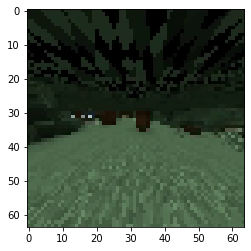

In [35]:
q_model = keras.models.clone_model(target_model)
q_model.set_weights(target_model.get_weights())

def train_model(target_model, q_model, n_epochs=100):
    tau = 10
    discount_factor = 0.95
    
    for epoch in range(n_epochs):
        video, actions, compass_angle, rewards = generate_random_video(path)

        print(epoch)
        batch = np.random.randint(video.shape[0])
        
        video = np.array(video[batch-4:batch])
        actions = np.array(actions[batch])
        rewards = np.array(rewards[batch])
        
        frames = stack_frames(video, compass_angle[batch]).reshape(1, 64, 64, 5)
        print(frames.shape)
        
        for a in range(len(actions)):
            if actions[a] != 0:
                if actions[a] != 1:
                    actions[a] = 1
        
        target_values = target_model.predict(frames)
        max_target_values = np.max(target_values, axis=1)
        target_Q_values = (rewards +
                          discount_factor * max_target_values)
        mask = tf.one_hot(actions, 11)
        with tf.GradientTape() as tape:
            all_Q_values = q_model(frames)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        
        grads = tape.gradient(loss, q_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, q_model.trainable_variables))
        
        if epoch % tau == 0:
            target_model.set_weights(q_model.get_weights())

train_model(target_model, q_model)

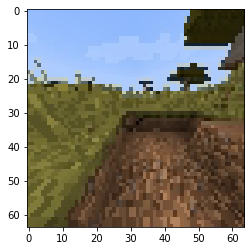

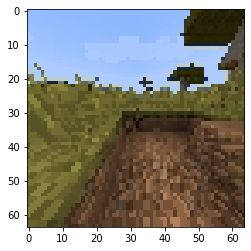

1/1 [==============================] - 0s 2ms/step - loss: 8.3409
Guessed actions:  [[-1.700e+01  9.067e+03  7.600e+01 -4.800e+01  7.700e+01 -1.400e+01
   5.100e+01 -5.000e+00 -2.800e+01 -5.100e+01  2.500e+01]]
Actual actions:  ['0' '0' '0' '0' '0' '0' '0' '1' '-0.0' '0.005127843' '0']


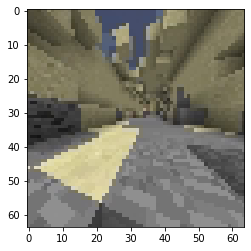

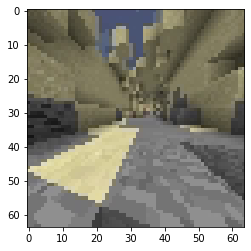

1/1 [==============================] - 0s 5ms/step - loss: 8.3337
Guessed actions:  [[-4.900e+01  8.247e+03  6.200e+01 -4.400e+01  8.000e+01 -2.600e+01
   4.900e+01 -3.000e+00 -4.800e+01 -6.100e+01  3.300e+01]]
Actual actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0.0' '0.0' '0']


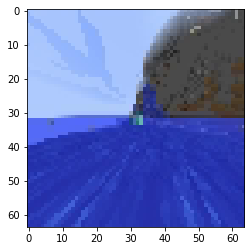

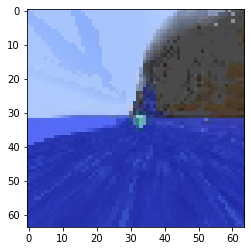

1/1 [==============================] - 0s 8ms/step - loss: 5.5663
Guessed actions:  [[ -20. 9701.   56.  -63.   78.  -19.   53.  -12.  -68.  -91.   17.]]
Actual actions:  ['1' '1' '0' '0' '1' '0' '0' '0' '-0.0' '0.0037071228' '0']


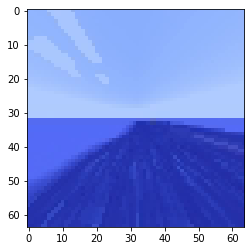

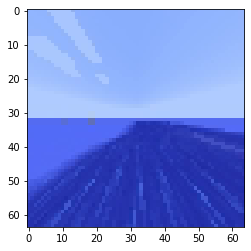

1/1 [==============================] - 0s 3ms/step - loss: 6.9474
Guessed actions:  [[-6.3000e+01  1.0443e+04  5.2000e+01 -9.5000e+01  8.7000e+01 -1.9000e+01
   7.2000e+01  7.0000e+00 -5.7000e+01 -7.1000e+01  1.8000e+01]]
Actual actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0.0' '0.0' '0']


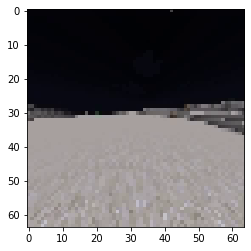

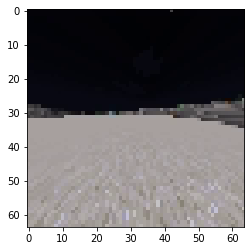

1/1 [==============================] - 0s 6ms/step - loss: 6.9474
Guessed actions:  [[-4.40e+01  4.57e+03  2.40e+01 -1.90e+01  3.90e+01 -2.70e+01  2.50e+01
  -3.00e+00 -3.00e+01 -1.20e+01  2.40e+01]]
Actual actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0.0' '0.0' '0']


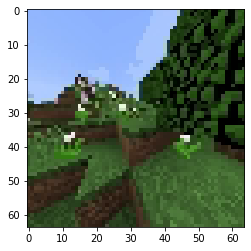

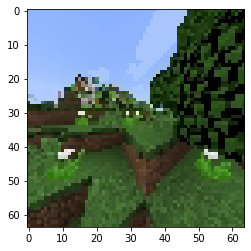

1/1 [==============================] - 0s 5ms/step - loss: 6.9474
Guessed actions:  [[-1.400e+01  8.769e+03  8.100e+01 -5.200e+01  6.900e+01 -6.000e+00
   4.300e+01  7.000e+00 -5.500e+01 -7.000e+01  1.600e+01]]
Actual actions:  ['1' '1' '0' '0' '1' '0' '0' '0' '0.0' '0.0' '0']


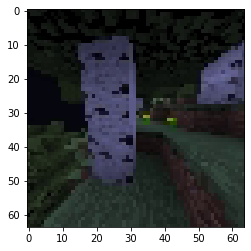

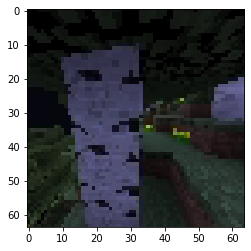

1/1 [==============================] - 0s 5ms/step - loss: 6.9474
Guessed actions:  [[-5.000e+00  3.119e+03  1.800e+01 -8.000e+00  2.700e+01 -2.800e+01
  -9.000e+00  2.000e+00 -1.200e+01 -8.000e+00  2.400e+01]]
Actual actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0.0' '0.0' '0']


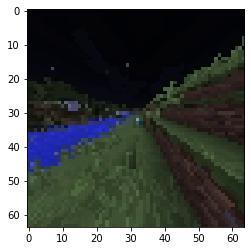

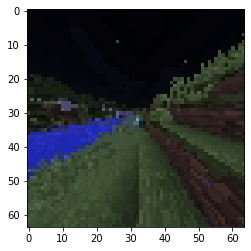

1/1 [==============================] - 0s 4ms/step - loss: 8.3419
Guessed actions:  [[ -38. 4584.   16.  -19.   32.  -27.    8.   -9.  -19.   -6.   21.]]
Actual actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0.0008333312' '0.0049997964' '0']


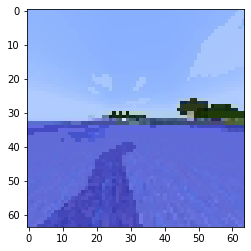

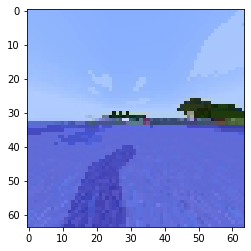

1/1 [==============================] - 0s 11ms/step - loss: 6.9474
Guessed actions:  [[  -57. 10642.    50.   -85.    80.   -17.    70.    12.   -72.   -87.
     26.]]
Actual actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0.0' '0.0' '0']


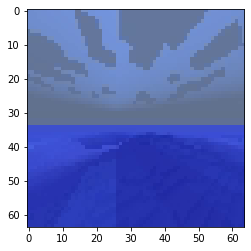

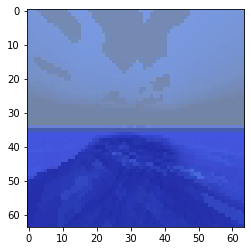

1/1 [==============================] - 0s 2ms/step - loss: 6.9942
Guessed actions:  [[-4.000e+01  9.335e+03  6.500e+01 -5.100e+01  8.400e+01 -1.500e+01
   5.300e+01 -1.100e+01 -6.400e+01 -6.700e+01  5.000e+00]]
Actual actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0.00085464056' '0.0324763' '0']


In [39]:
for i in range(10):    
    video, actions, compass_angle, rewards = generate_random_video(path)

    batch = np.random.randint(video.shape[0])
    video = np.array(video[batch-4:batch])

    plt.imshow(video[0].astype(np.uint8))
    plt.show()

    plt.imshow(video[-1].astype(np.uint8))
    plt.show()

    actions = np.array(actions[batch])
    frames = stack_frames(video, compass_angle[batch]).reshape(1, 64, 64, 5)

    target_model.evaluate(frames, np.array(actions).astype(np.float32).reshape(1, 11))

    print("Guessed actions: ", np.round(target_model.predict(frames)))
    print("Actual actions: ", actions)

In [40]:
target_model.save("target_q_model.h5")
q_model.save("q_model.h5")